In [ ]:
import pandas as pd
from NEExT.io import GraphIO
import igraph as ig
from matplotlib import pyplot as plt

%reload_ext autoreload
%autoreload 2

/home/quak/development/NEExT/.venv/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [ ]:
edges_df = pd.read_csv("data/chain", delimiter=" ", header=None)
edges_df.columns = ["src_node_id", "dest_node_id"]

nodes = list(set(edges_df["src_node_id"].unique().tolist() + edges_df["dest_node_id"].unique().tolist()))
features_df = pd.DataFrame()
features_df["node_id"] = nodes
# for this problem as an outlier we define nodes at the edges
features_df["is_outlier"] = 0
features_df.loc[[0, len(features_df) - 1], "is_outlier"] = 1

mapping_df = pd.DataFrame()
mapping_df["node_id"] = nodes
mapping_df["graph_id"] = 0

In [4]:
graph_io = GraphIO()
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)

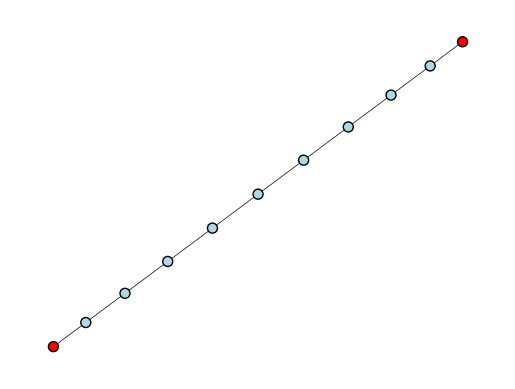

In [24]:
graph = graph_collection.graphs[0].G

node_colors = ["red" if node["is_outlier"] else "lightblue" for node in graph.vs]
edge_colors = ["black" for _ in graph.es]
layout = graph.layout("fr")

visual_style = {}
visual_style["vertex_size"] = 10
visual_style["vertex_color"] = node_colors
visual_style["edge_color"] = edge_colors
visual_style["edge_width"] = 0.5
visual_style["layout"] = layout
visual_style["vertex_label"] = None
visual_style["bbox"] = (600, 600)
visual_style["margin"] = 20


fig, ax = plt.subplots()
ig.plot(graph, target=ax, **visual_style)
plt.show()

In [39]:
# the caputring if the specific nodes has an outlier in its neighborhood
k_hop = 2
outlier_in_neighbors = []

outlier_nodes = features_df.query("is_outlier == 1")["node_id"].tolist()
for node in range(graph.vcount()):
    neighbors = list(i for i in graph.neighborhood(node, order=k_hop) if i != node)
    print(node, neighbors)
    if any(n in outlier_nodes for n in neighbors):
        outlier_in_neighbors.append(1)
    else:
        outlier_in_neighbors.append(0)

0 [1, 2]
1 [0, 2, 3]
2 [1, 3, 0, 4]
3 [2, 4, 1, 5]
4 [3, 5, 2, 6]
5 [4, 6, 3, 7]
6 [5, 7, 4, 8]
7 [6, 8, 5, 9]
8 [7, 9, 6, 10]
9 [8, 10, 7]
10 [9, 8]


In [38]:
outlier_in_neighbors

[0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0]